In [2]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model

import sklearn
from sklearn.model_selection import ParameterGrid
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Counts')

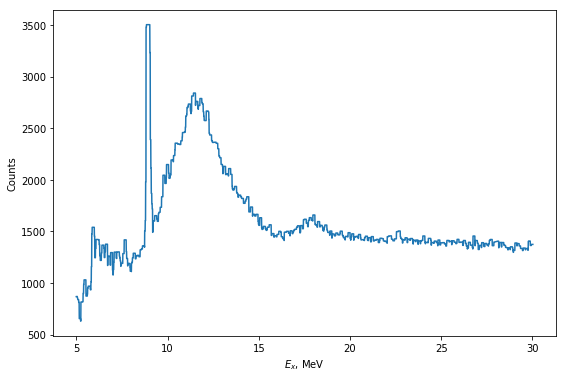

In [3]:
Ga_5_28 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/5_28.csv', 
                      sep='\t', decimal=',')

plt.figure(figsize=(9,6))
plt.plot(Ga_5_28['x'].values, Ga_5_28['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
#plt.ylim(0,6)

Text(0,0.5,'Counts')

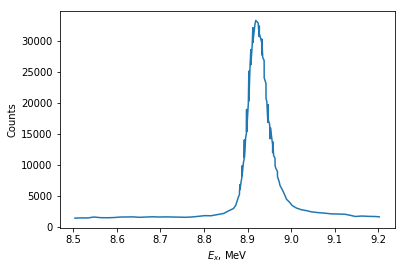

In [4]:
IAS = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/IAS.csv', 
                      sep='\t', decimal=',')
IAS['y'] = IAS['y'] * 1000
plt.plot(IAS['x'].values, IAS['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
#plt.xlim(8.9,9)

Text(0,0.5,'Counts')

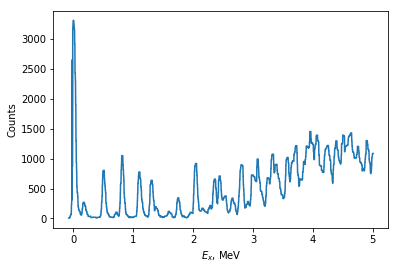

In [5]:
Ga_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Ga/plots/2015/0_5.csv', 
                      sep='\t', decimal=',')
plt.plot(Ga_0_5['x'].values, Ga_0_5['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')

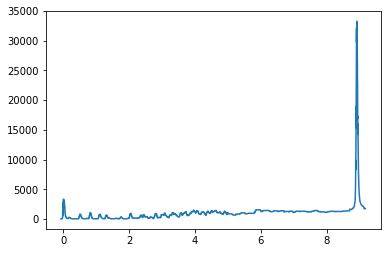

In [23]:
beginning = Ga_5_28[((Ga_5_28['x']<8.7))]
middle = IAS[((IAS['x']>8.7) & (IAS['x']<9.18))]
ending = Ga_5_28[((Ga_5_28['x']>9.18) & (Ga_5_28['x']<9.5))]

#data = Ga_0_5.append(beginning).append(middle).append(ending)
data = Ga_0_5.append(beginning).append(middle)

plt.plot(data['x'].values, data['y'].values)

(0, 20)

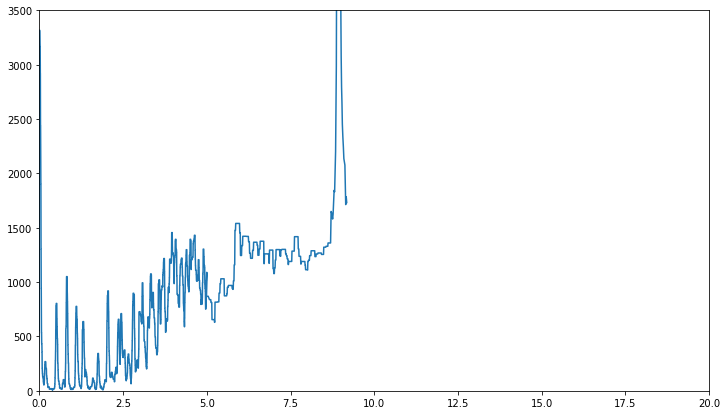

In [24]:
plt.figure(figsize=(12,7))
plt.plot(data['x'].values, data['y'].values)
plt.ylim(0,3500)
plt.xlim(0,20)

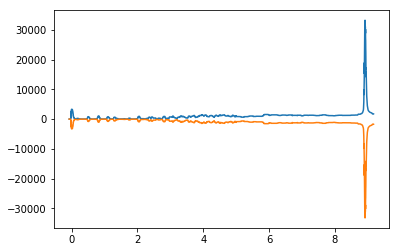

In [25]:
plt.plot(data['x'].values, data['y'].values)
plt.plot(data['x'].values, -data['y'].values)

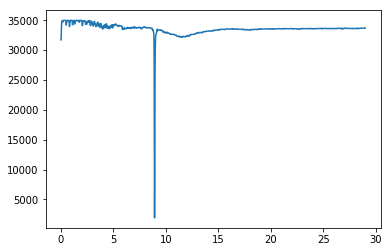

In [8]:
x_data = np.linspace(0,29,len(data['x'].values))
y_data = np.interp(x_data, data['x'].values, data['y'].values)
#plt.plot(x_data, y_data)
plt.plot(x_data, -y_data+35000)

(0, 5000)

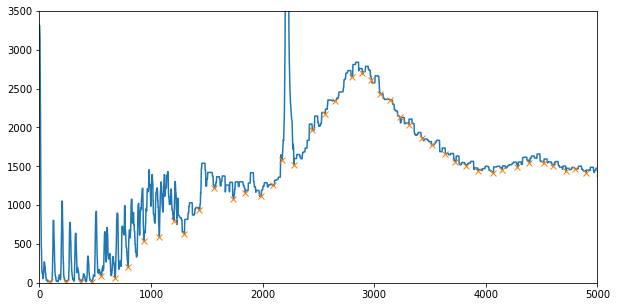

In [9]:
peaks, _ = sc.signal.find_peaks(-y_data+35000, distance=80)
plt.figure(figsize=(10,5))
plt.plot(y_data)
plt.plot(peaks, y_data[peaks], "x")
plt.ylim(0,3500)
plt.xlim(0,5000)

(8.7, 9.2)

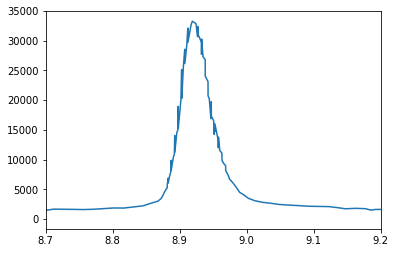

In [10]:
plt.plot(data['x'].values, data['y'].values)
plt.xlim(8.7,9.2)

(8.5, 9.2)

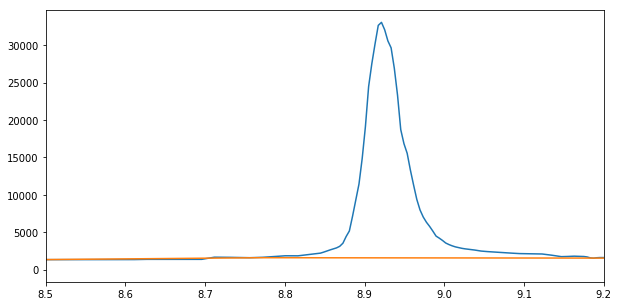

In [11]:
y_data2 = np.interp(x_data, x_data[peaks], y_data[peaks])
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data)
plt.plot(x_data, y_data2)
plt.xlim(8.5,9.2)

(0, 3500)

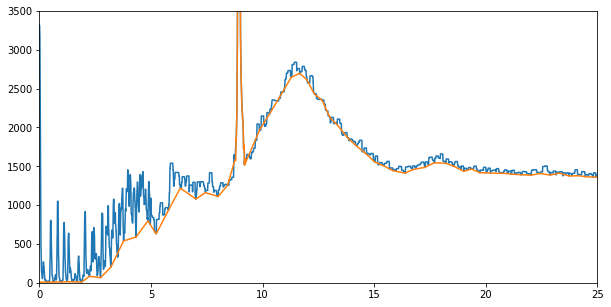

In [31]:
temp1 = pd.DataFrame({'x':x_data, 'y':y_data})
temp2 = pd.DataFrame({'x':x_data, 'y':y_data2})

data3 = temp2[(temp2['x']<8.8)].append(temp1[((temp1['x']>8.8) & (temp1['x']<9.2))]).append(temp2[(temp2['x']>9.2)])

plt.figure(figsize=(10,5))
plt.plot(temp1['x'].values, temp1['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
plt.xlim(0,25)
plt.ylim(0,3500)

In [13]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [16]:
def QFC_back3(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

def QFC_back4(x, E_qf, N_0):
    W = 22
    T = 100
    Q_EC_71Ge=0.232
    S_p_71Ge=8.285
    E_t_gs = 420 - Q_EC_71Ge
    E_0 = E_t_gs - S_p_71Ge
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [26]:
#np.random.seed(150)

total_mod = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3,prefix='pigmy2_') \
+Model(breit_vigner3,prefix='IAS1_') \
+Model(breit_vigner3, prefix='GTR_') \
+Model(breit_vigner3, prefix='SDR_') \
+Model(QFC_back4, prefix='QFC_back_')

total_mod.set_param_hint('pigmy1_w', value=4.5, min=3, max=5)
total_mod.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=3)
total_mod.set_param_hint('pigmy1_M', value=5, min=1, max=5000)

total_mod.set_param_hint('pigmy2_w', value=6, min=4, max=8)
total_mod.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=5)
total_mod.set_param_hint('pigmy2_M', value=1, min=1, max=5000)

total_mod.set_param_hint('IAS1_w', value=8.913, min=8.8, max=9.1) #возможно ошибка в оцифровке, если фиксировать значение, то пик получается смещенным
total_mod.set_param_hint('IAS1_G1', value=0.01, min=0.01, max=0.04)
total_mod.set_param_hint('IAS1_M', value=0.5, min=0.5, max=5000)

total_mod.set_param_hint('GTR_w', value=11.75, min=11, max=13)
total_mod.set_param_hint('GTR_G1', value=2, min=2, max=5)
total_mod.set_param_hint('GTR_M', value=0.5, min=0.1, max= 10000)

total_mod.set_param_hint('SDR_w', value=15, min=12, max=20)
total_mod.set_param_hint('SDR_G1', value=0.01, min=0.1, max=10)
total_mod.set_param_hint('SDR_M', value=0.5, min=0.1, max= 3000)

total_mod.set_param_hint('QFC_back_E_qf', value=400, max=410, min=380 )
total_mod.set_param_hint('QFC_back_N_0', value=8, min=1, max=15000 )

pars = total_mod.make_params()

total_mod_result = total_mod.fit(data3['y'].values, pars, x=data3['x'].values, 
                                 method='differential_evolution')

print(total_mod_result.fit_report())

[[Model]]
    (((((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='IAS1_')) + Model(breit_vigner3, prefix='GTR_')) + Model(breit_vigner3, prefix='SDR_')) + Model(QFC_back4, prefix='QFC_back_'))
[[Fit Statistics]]
    # function evals   = 43897
    # data points      = 7198
    # variables        = 17
    chi-square         = 154685539.596
    reduced chi-square = 21540.947
    Akaike info crit   = 71836.543
    Bayesian info crit = 71953.530
[[Variables]]
    pigmy1_M:        200.564093 (init= 5)
    pigmy1_w:        4.54549675 (init= 4.5)
    pigmy1_G1:       0.71523742 (init= 0.1)
    pigmy2_M:        768.689773 (init= 1)
    pigmy2_w:        6.57530568 (init= 6)
    pigmy2_G1:       1.09686855 (init= 0.1)
    IAS1_M:          741.232916 (init= 0.5)
    IAS1_w:          8.92393790 (init= 8.913)
    IAS1_G1:         0.02210945 (init= 0.01)
    GTR_M:           5337.38575 (init= 0.5)
    GTR_w:           11.4142051 (init= 

(0, 3500)

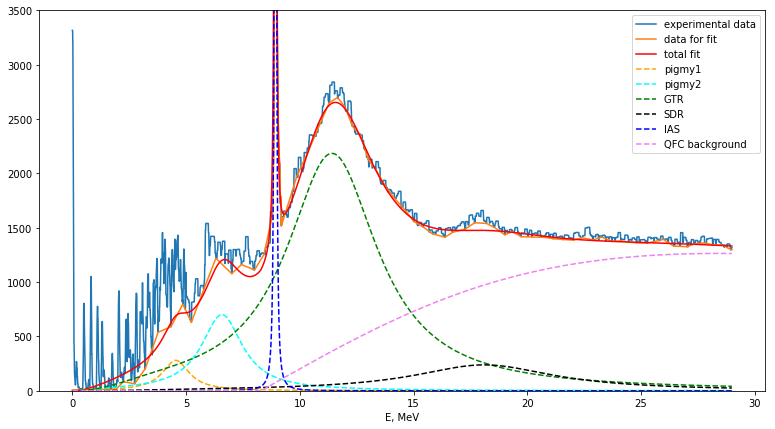

In [35]:
total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(temp1['x'].values, temp1['y'].values, label='experimental data')
plt.plot(data3['x'].values, data3['y'].values, label='data for fit')
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS ')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.ylim(0,3500)

(8.5, 9.2)

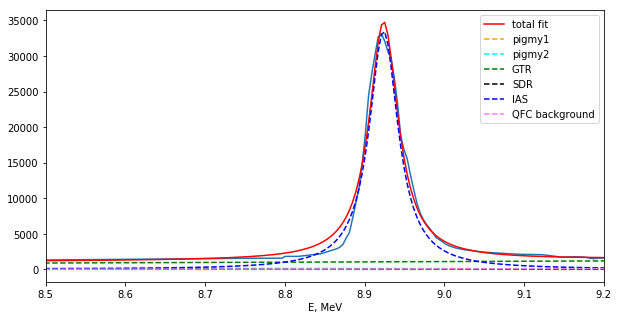

In [28]:
plt.figure(figsize=(10,5))
#plt.plot(data['x'].values, data['y'].values)
plt.plot(data3['x'].values, data3['y'].values)
#plt.plot(temp2['x'].values, temp2['y'].values)
plt.plot(data3['x'].values, total_mod_result.best_fit, 'r-', label='total fit')
plt.plot(data3['x'].values, total_mod_comps['pigmy1_'], 'orange', label='pigmy1', ls='--')
plt.plot(data3['x'].values, total_mod_comps['pigmy2_'], 'cyan', label='pigmy2', ls='--')
plt.plot(data3['x'].values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(data3['x'].values, total_mod_comps['SDR_'], 'black', label='SDR', ls='--')
plt.plot(data3['x'].values, total_mod_comps['IAS1_'], 'b--', label='IAS ')
plt.plot(data3['x'].values, total_mod_comps['QFC_back_'], 'violet', label='QFC background', ls='--')
#plt.plot(IAS_red['x'].values, comps['line_'], 'b--')
plt.legend()
plt.xlabel('E, MeV')
#plt.ylabel('S(E), 1/MeV')
plt.xlim(8.5,9.2)